<a href="https://colab.research.google.com/github/amankrpandey1/captcha-solver/blob/main/captcha_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Captcha Solver

###Unzip the folder

In [1]:
!unzip '/content/Gujarat_Rural_Captchas.zip'

Archive:  /content/Gujarat_Rural_Captchas.zip
   creating: Gujarat_Rural_Captchas/
  inflating: __MACOSX/._Gujarat_Rural_Captchas  
  inflating: Gujarat_Rural_Captchas/108917.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._108917.png  
  inflating: Gujarat_Rural_Captchas/113489.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._113489.png  
  inflating: Gujarat_Rural_Captchas/114480.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._114480.png  
  inflating: Gujarat_Rural_Captchas/306982.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._306982.png  
  inflating: Gujarat_Rural_Captchas/108730.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._108730.png  
  inflating: Gujarat_Rural_Captchas/116268.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._116268.png  
  inflating: Gujarat_Rural_Captchas/109348.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._109348.png  
  inflating: Gujarat_Rural_Captchas/107365.png  
  inflating: __MACOSX/Gujarat_Rural_Captchas/._107365.pn

##Importing necessary libs

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,MaxPooling2D,Conv2D,BatchNormalization,Dense,Dropout,Flatten
from tensorflow.keras.saving import load_model
import os
import random
import numpy as np
import cv2

##Data Analysis and Preprocessing

In [57]:
n=os.listdir("/content/Gujarat_Rural_Captchas")
len(n) #number of images

1774

In [58]:
n[:5]

['103967.png', '110839.png', '110312.png', '114240.png', '102510.png']

In [59]:
#check other than png files
frmt = [i for i in n if "png" not in i]
print(frmt)

[]


In [60]:
# check for captcha length and content inside it
lens = [len(i) for i in n]
set(lens)


{10, 11}

In [61]:
#one or more than one image is having len 10 and 11 lets check
[i for i in n if len(i)>10]

['0590845.png']

In [62]:
# only one sample is there so there is no such issue we can delete it
n.remove('0590845.png')

In [63]:
#check for any other character  than numbers in captcha
[i for i in n if not i.split(".")[0].isdigit()]

[]

In [64]:
digits = 6 #total 6 digits are present in each captcha
character="0123456789" # there are numbers from 0 to 9 are present in the captcha
nchar=len(character)
nchar

10

In [72]:
def preprocess(folder_path):

  img_list = n

  X = np.zeros((len(n),80,190,1)) #80,190 is image resolution h*w
  #6*1773*10(6 letters in captcha) with all entries 0
  y=  np.zeros((digits,len(n),nchar)) #(6,1773,10) 6 dim arr containing 10 char for each image in 1773 images

  random.shuffle(img_list) #shuffle the list of images

  for i, pic in enumerate(img_list):
    img = cv2.imread(os.path.join(folder_path,pic),cv2.IMREAD_GRAYSCALE) #convert each image to grayscale
    pic_target = pic[:-4] #removing .png

    if len(pic_target) <= digits:
      img = img/255.0
      img = np.reshape(img,(80,190,1))

      target = np.zeros((digits,nchar))

      for j, k in enumerate(pic_target):
        index = character.find(k) #index stores the position of letter k of captcha in the character string
        target[j,index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha
      X[i] = img
      y[:,i] = target
  return X,y

In [67]:
X,y = preprocess("/content/Gujarat_Rural_Captchas")
print(X.shape,y.shape)

(1773, 80, 190, 1) (6, 1773, 10)


(1773, 1773)

##Training and Test Data Preparation

In [34]:

X_train,y_train = X[:1700],y[:,:1700]
X_test,y_test = X[1700:],y[:,1700:]

##Defining Model Archietechture

In [38]:
def create_model():
  img = Input(shape = (80,190,1))
  conv1 = Conv2D(filters=16,kernel_size=(3, 3),padding='same',activation='relu')(img)
  mp1 = MaxPooling2D(padding="same")(conv1)
  conv2 = Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu')(mp1)
  mp2 = MaxPooling2D(padding="same")(conv2)
  conv3 = Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu')(mp2)
  bn = BatchNormalization()(conv3)
  mp3 = MaxPooling2D(padding="same")(bn)

  flat = Flatten()(mp3)

  outs=[]

  for _ in range(6):
    dens = Dense(64,activation="relu")(flat)
    drop = Dropout(0.5)(dens)
    res = Dense(nchar,activation="sigmoid")(drop)

    outs.append(res)

  model = Model(img,outs)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model


In [35]:
model = create_model()

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 190, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 190, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 95, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 40, 95, 32)   4640        ['max_pooling2d[0][0]']      

##Model Training

In [ ]:
# 6 output layers which will predict 6 diff digits present in captcha
hist = model.fit(X_train,[y_train[0],y_train[1],y_train[2],y_train[3],y_train[4],y_train[5]],
                 batch_size=32,epochs=150,validation_split=0.2)

##Model Evaluation

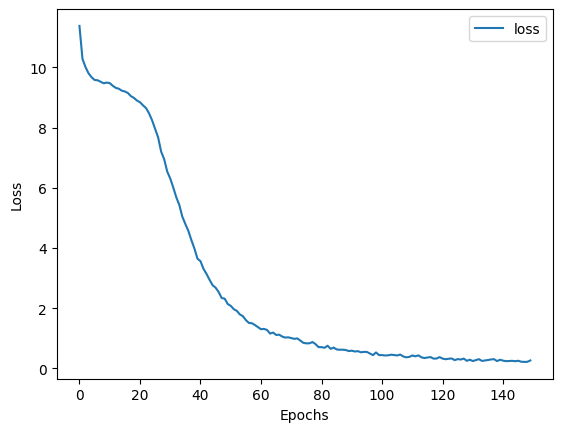

In [37]:
import matplotlib.pyplot as plt
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.metrics_names # total loss, followed by 6 losses and 6 accuracies of diff  output layers

['loss',
 'dense_97_loss',
 'dense_99_loss',
 'dense_101_loss',
 'dense_103_loss',
 'dense_105_loss',
 'dense_107_loss',
 'dense_97_accuracy',
 'dense_99_accuracy',
 'dense_101_accuracy',
 'dense_103_accuracy',
 'dense_105_accuracy',
 'dense_107_accuracy']

In [48]:
hist.history.keys()

dict_keys(['loss', 'dense_1_loss', 'dense_3_loss', 'dense_5_loss', 'dense_7_loss', 'dense_9_loss', 'dense_11_loss', 'dense_1_accuracy', 'dense_3_accuracy', 'dense_5_accuracy', 'dense_7_accuracy', 'dense_9_accuracy', 'dense_11_accuracy', 'val_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_5_loss', 'val_dense_7_loss', 'val_dense_9_loss', 'val_dense_11_loss', 'val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy', 'val_dense_11_accuracy'])

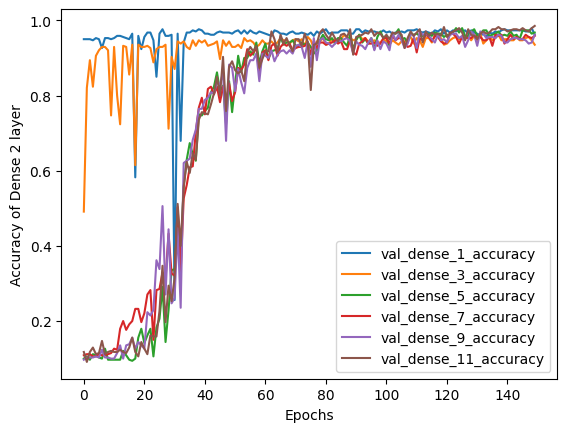

In [50]:
#graph of accuracy of dense_2 vs epochs
for label in ['val_dense_1_accuracy', 'val_dense_3_accuracy', 'val_dense_5_accuracy', 'val_dense_7_accuracy', 'val_dense_9_accuracy', 'val_dense_11_accuracy']:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of All 6 Dense layers")
plt.show()

In [54]:
preds_train = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4],y_train[5]],verbose=0)

preds_test = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4],y_test[5]],verbose=0)

In [52]:
overall_accuracy_train  = (np.sum(preds_train[7:])/6)
overall_accuracy_train

0.992254912853241

In [53]:
overall_accuracy_test  = (np.sum(preds_test[7:])/6)
overall_accuracy_test

0.965753416220347

##Model Prediction

In [ ]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1
    #returns array of size 1*6*10
    result = np.reshape(res, (6, 10)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt

In [ ]:
print("Predicted Captcha =",predict('/content/Gujarat_Rural_Captchas/100109.png'))

1/1 [==============================] - 0s 21ms/step
Predicted Captcha = 100109


## Model Saving

In [ ]:
model.save("captcha_solver.h5")